In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import math
!pip install pywaffle
import pywaffle
import scipy
import plotly.express as px
from pywaffle import Waffle

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [9]:
train = pd.read_csv('../input/the14thstatistikaria/train.csv')
test = pd.read_csv('../input/the14thstatistikaria/test.csv')
train_original = pd.read_csv('../input/the14thstatistikaria/train.csv')
test_original = pd.read_csv('../input/the14thstatistikaria/test.csv')
sample_submission = pd.read_csv('../input/the14thstatistikaria/sample_submission.csv')

In [10]:
train.head()

,MSISDN,los,rchg_rev,rchg_trx,voice_rev,voice_trx,voice_mou,voice_dou,sms_rev,sms_trx,...,broadband_usg,broadband_dou,digital_rev,digital_trx,digital_dou,voice_package_rev,voice_package_trx,voice_package_dou,package_last_purchase,lapsed_flag
0,1,1175,30000,3,11637.0,114,121,6,1480,21,...,6.804641,7,660.0,5,2,7500,3,2,2,0
1,2,17044,10000,1,8073.0,11,3,4,620,3,...,0.002163,2,0.0,0,0,2500,1,1,3,1
2,4,943,50000,1,17434.0,72,149,7,5245,32,...,0.000000,0,0.0,0,0,19550,5,5,2,0
3,5,2319,30000,4,4583.0,13,104,5,5495,28,...,0.000000,0,0.0,0,0,12800,3,2,2,0
4,6,975,0,0,2390.0,9,15,3,3010,16,...,0.000000,0,165.0,1,1,4100,1,1,4,1


In [11]:
test.head()

,MSISDN,los,rchg_rev,rchg_trx,voice_rev,voice_trx,voice_mou,voice_dou,sms_rev,sms_trx,...,broadband_rev,broadband_usg,broadband_dou,digital_rev,digital_trx,digital_dou,voice_package_rev,voice_package_trx,voice_package_dou,package_last_purchase
0,3,185,25000,1,416.0,3,151,3,3520,18,...,0.0,1250.488211,7,350.0,2,1,8700,2,2,2
1,10,209,0,0,640.0,26,217,4,4180,23,...,0.0,0.000000,0,1225.0,2,2,2500,1,1,3
2,12,931,10000,2,0.0,12,127,2,860,4,...,0.0,0.000000,0,25.0,1,1,4350,1,1,6
3,23,745,15000,2,12436.0,12,40,5,3805,19,...,0.0,0.000000,0,0.0,0,0,5000,2,2,0
4,27,219,60000,5,30926.0,59,148,7,9245,46,...,0.0,0.000000,0,2145.0,13,4,27350,6,5,0


## Features information

In [12]:
train.columns

Index(['MSISDN', 'los', 'rchg_rev', 'rchg_trx', 'voice_rev', 'voice_trx',
       'voice_mou', 'voice_dou', 'sms_rev', 'sms_trx', 'sms_dou',
       'broadband_rev', 'broadband_usg', 'broadband_dou', 'digital_rev',
       'digital_trx', 'digital_dou', 'voice_package_rev', 'voice_package_trx',
       'voice_package_dou', 'package_last_purchase', 'lapsed_flag'],
      dtype='object')

- MSISDN : customer ID
- los : length of stay
- rchg_rev : revenue from top up
- rchg_trx : number of top up for the last 30 days
- voice_rev : revenue from voice service
- voice_trx : number of voice service transaction for the last 30 days
- voice_mou : voice service duration for the last 30 days (minutes)
- voice_dou : number of days using voice service for the last 30 days
- sms_rev : revenue from sms service
- sms_trx : number of sms service transaction for the last 30 days
- sms_dou : number of days using sms service for the last 30 days
- broadband_rev : revenue from internet service
- broadband_usg : internet service usage for the last 30 days (MB)
- broadband_dou : number of days using internet service for the last 30 days
- digital_rev : revenue from digital service
- digital_trx : number of digital service transaction for the last 30 days
- digital_dou : number of days using digital service for the last 30 days
- voice_package_rev : revenue from voice_package service
- voice_package_trx : number of voice_package service transaction for the last 30 days
- voice_package_dou : number of days using voice_package service for the last 30 days
- package_last_purchase : 0 to 6
- lapsed_flag : 0 (non churn), 1(churn)

# Checking if the dataset contains missing value

In [13]:
print(train[train.isnull().any(axis = 1)].shape[0])
print(test[test.isnull().any(axis = 1)].shape[0])

0
0


no missing value for both training and testing set

# EDA

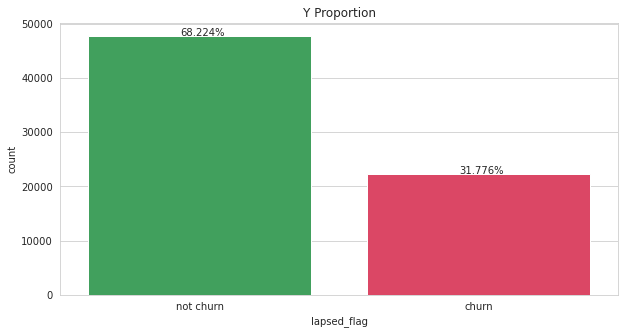

In [14]:
plt.figure(figsize = [10, 5])
sns.set_style('whitegrid')
sns.countplot(train['lapsed_flag'], palette = ['#31B057', '#F42E56'])
plt.xticks([0, 1], ['not churn', 'churn'])
plt.title('Y Proportion')
for index, value in enumerate([train[train['lapsed_flag'] == 0].shape[0], train[train['lapsed_flag'] == 1].shape[0]]) :
    plt.text(index-.07, value, '%.3f'%(value*100/train.shape[0]) + '%')

From the countplot obtained above, the Y proportion is imbalanced. This is quite common and can be found in other kind of classification  task like fraud, or spam classification where the positive class is actually much less than the negative class. Because of this condition, F1 score is more appropiate to measure model(s) performance than accuracy.

First, a subplot consists of distribution plot of numerical (continuous) features will be generated in order to have a better understanding of the dataset.

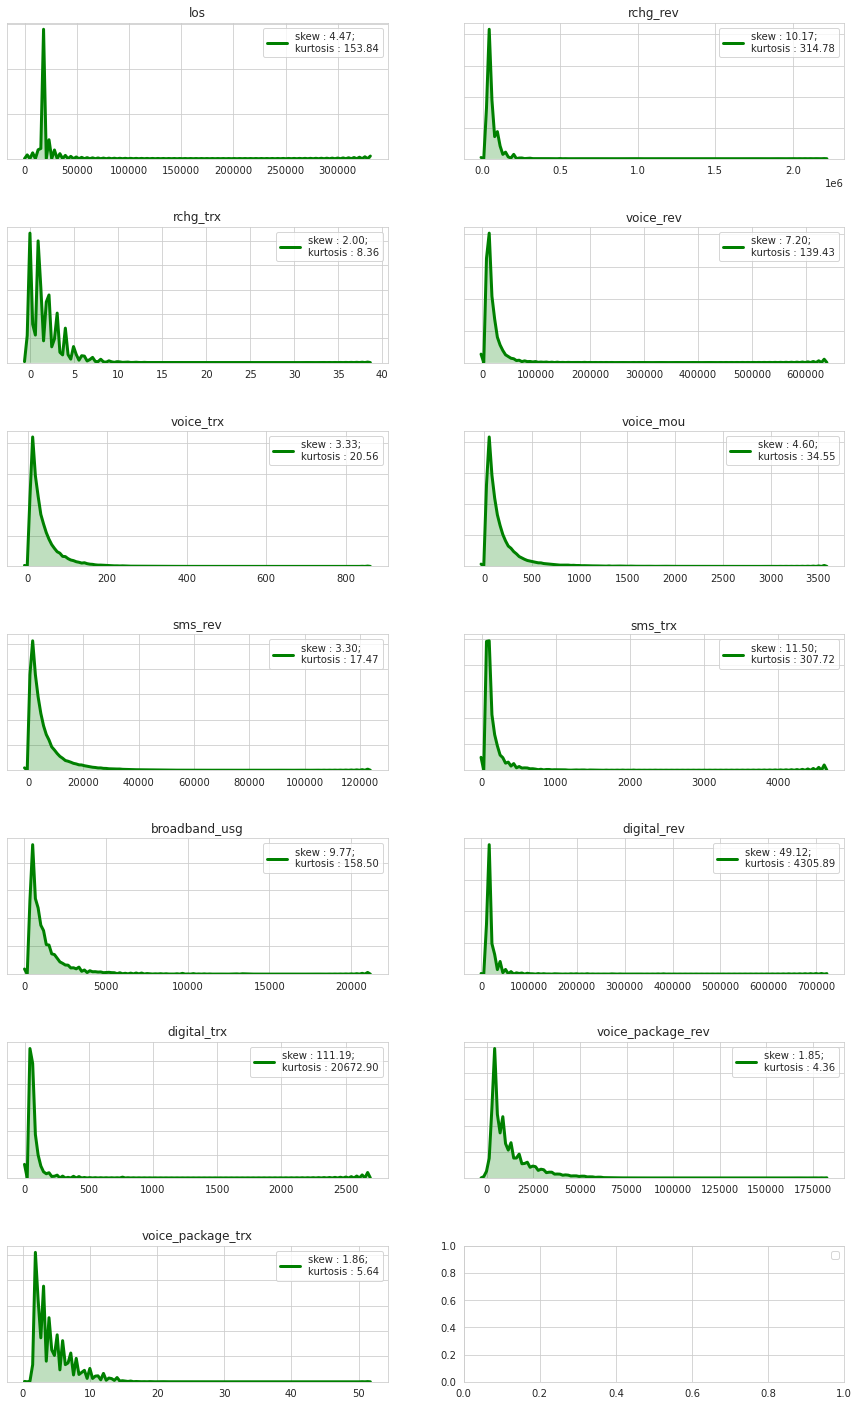

In [15]:
numerical_features = list(train.drop(columns = ['MSISDN', 
                                                'package_last_purchase', 
                                                'lapsed_flag',
                                                'voice_dou', 
                                                'sms_dou', 
                                                'broadband_dou', 
                                                'digital_dou', 
                                                'voice_package_dou']).columns)
fig, ax = plt.subplots(7, 2, figsize = [15, 25])
i = 0
fail = []
for feature in numerical_features :
    try :
        sns.distplot(train[feature],
                     ax = ax[i//2, i%2],
                     hist = False,
                     color = 'green',
                     kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3},
                     label = 'skew : {skew}; \nkurtosis : {kurtosis}'.format(skew = '%.2f'%train[feature].skew(),
                                                                         kurtosis = '%.2f'%train[feature].kurtosis()))
        
        ax[i//2, i%2].set_xlabel('')
        ax[i//2, i%2].set_yticklabels('')
        ax[i//2, i%2].set_title(feature)
        i += 1
        plt.subplots_adjust(hspace = .5)
        plt.legend()
    except : 
        fail.append(feature)
        pass

In [16]:
fail

['broadband_rev']

There are some features that have high skew and kurtosis like broadband_usg and also broadband_rev. broadband_rev is not available at the above plot because it has so many zeros

There are 5 kind of services that are covered in this dataset. To make it easier to understand, I will dig into each services one by one.

Voice features

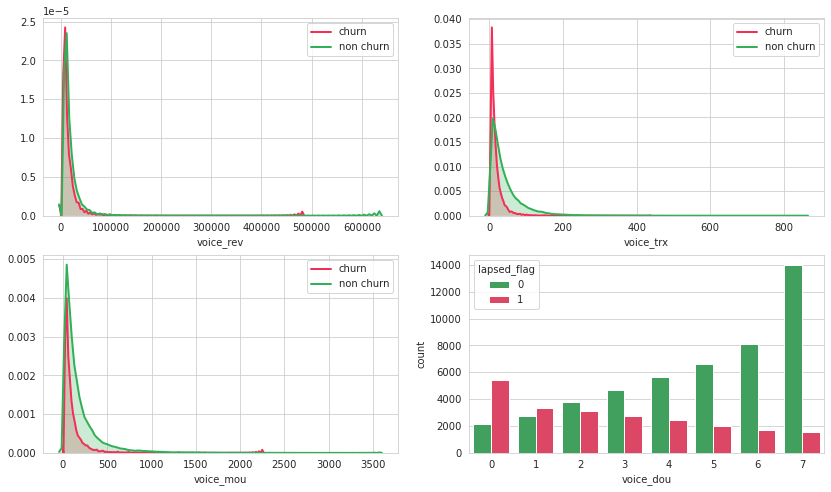

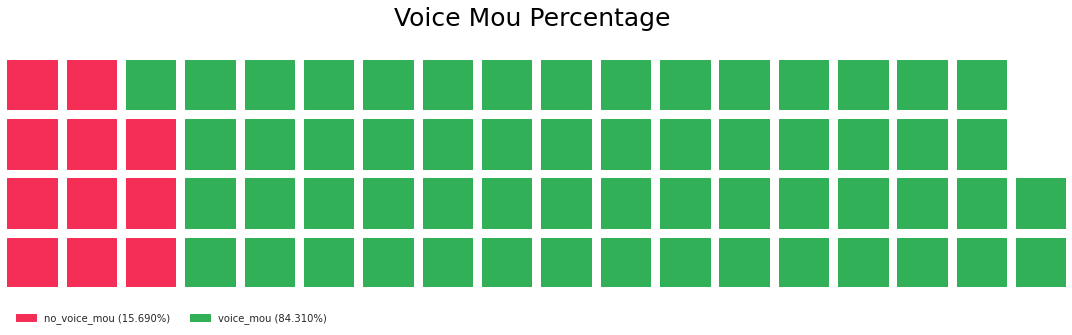

In [17]:
#palette = ['#31B057', '#F42E56']
fig, ax = plt.subplots(2, 2, figsize = [14, 8])
i = 0
for feature in ['voice_rev', 'voice_trx', 'voice_mou', 'voice_dou'] :
    if i != 3 :
        sns.distplot(train[train['lapsed_flag'] == 1][feature],
                    ax = ax[i//2, i%2],
                    hist = False,
                    kde = True,
                    kde_kws = {'shade' : True,
                               'linewidth' : 2},
                    label = 'churn',
                    color = '#F42E56')
        sns.distplot(train[train['lapsed_flag'] == 0][feature],
                     hist = False,
                     kde = True,
                     kde_kws = {'shade' : True,
                           'linewidth' : 2},
                     label = 'non churn',
                     ax = ax[i//2, i%2],
                     color = '#31B057')
        i += 1
        
    else :
        
        sns.countplot(data = train[['voice_dou', 'lapsed_flag']],
                      hue = 'lapsed_flag',
                      x = 'voice_dou',
                      ax = ax[i//2, i%2],
                      palette = ['#31B057', '#F42E56'],
                      hue_order = [0, 1])
        i += 1
        
data = {'no_voice_mou': train[train['voice_mou'] == 0]['voice_mou'].shape[0],
        'voice_mou' : train[train['voice_mou'] != 0]['voice_mou'].shape[0]}
fig = plt.figure(
    figsize = [15, 5],
    FigureClass=Waffle, 
    rows=4, 
    values=np.array(sorted(list(data.values())))/1000,
    labels=["{0} ({1}%)".format(k, '%.3f'%(v*100/train.shape[0])) for k, v in data.items()],
    colors = ('#F42E56', '#31B057'),
    #labels=["{0} ({1}%)".format(k, '%.2f'%(v*100/sum(dict(train[revenue_features].sum()).values()))) for k, v in data.items()],
    title={'label': 'Voice Mou Percentage \n', 'loc': 'center', 'size' : 25, 'color' : 'black'},
    #labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 
            'bbox_to_anchor': (0, -0.2), 
            'ncol': len(data), 
            'framealpha': 0}
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('white')
plt.show()

Interpretation :
- from voice_rev to voice_mou are right-skewed features and they share pretty much the same distributions between the churn and non churn customers
- For voice_dou feature, the longer the usage of the voice service, the less likely that customers will churn
- Only 15.69% Customers do not use voice service for the past month

SMS features

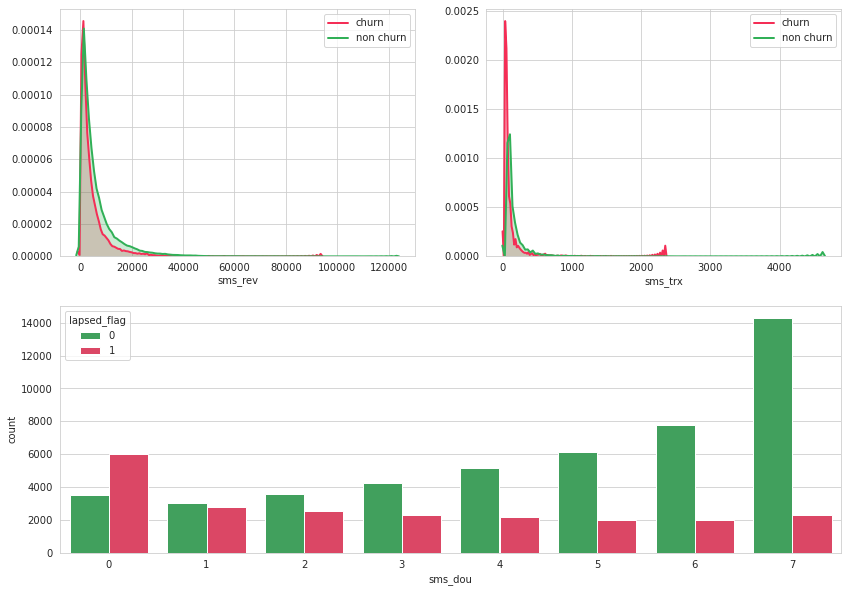

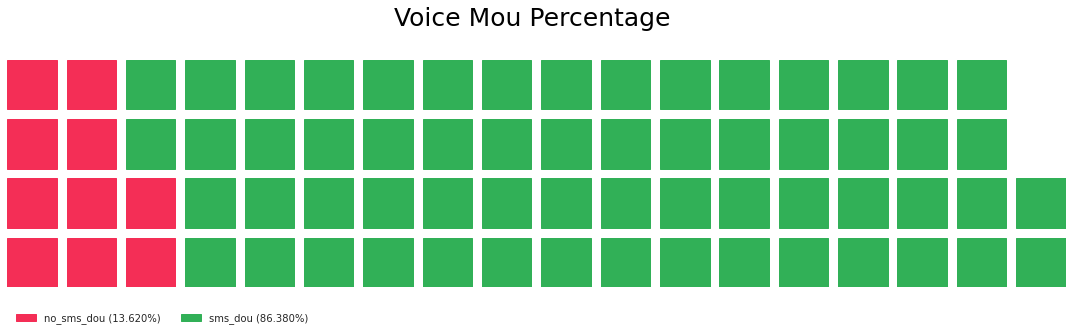

In [18]:
#palette = ['#31B057', '#F42E56']
fig = plt.figure(figsize = [14, 10])
ax1 = fig.add_subplot(2, 2, 1)
sns.distplot(train[train['lapsed_flag'] == 1]['sms_rev'],
            hist = False,
            kde = True,
            kde_kws = {'shade' : True,
                       'linewidth' : 2},
            label = 'churn',
            color = '#F42E56')
sns.distplot(train[train['lapsed_flag'] == 0]['sms_rev'],
             hist = False,
             kde = True,
             kde_kws = {'shade' : True,
                   'linewidth' : 2},
             label = 'non churn',
             color = '#31B057')
ax2 = fig.add_subplot(2, 2, 2)
sns.distplot(train[train['lapsed_flag'] == 1]['sms_trx'],
            hist = False,
            kde = True,
            kde_kws = {'shade' : True,
                       'linewidth' : 2},
            label = 'churn',
            color = '#F42E56')
sns.distplot(train[train['lapsed_flag'] == 0]['sms_trx'],
             hist = False,
             kde = True,
             kde_kws = {'shade' : True,
                   'linewidth' : 2},
             label = 'non churn',
             color = '#31B057')

ax3 = fig.add_subplot(2, 2, (3,4))
sns.countplot(data = train[['sms_dou', 'lapsed_flag']],
              hue = 'lapsed_flag',
              x = 'sms_dou',
              palette = ['#31B057', '#F42E56'],
              hue_order = [0, 1])

data = {'no_sms_dou': train[train['sms_dou'] == 0]['sms_dou'].shape[0],
        'sms_dou' : train[train['sms_dou'] != 0]['sms_dou'].shape[0]}
fig = plt.figure(
    figsize = [15, 5],
    FigureClass=Waffle, 
    rows=4, 
    values=np.array(sorted(list(data.values())))/1000,
    labels=["{0} ({1}%)".format(k, '%.3f'%(v*100/train.shape[0])) for k, v in data.items()],
    colors = ('#F42E56', '#31B057'),
    #labels=["{0} ({1}%)".format(k, '%.2f'%(v*100/sum(dict(train[revenue_features].sum()).values()))) for k, v in data.items()],
    title={'label': 'Voice Mou Percentage \n', 'loc': 'center', 'size' : 25, 'color' : 'black'},
    #labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 
            'bbox_to_anchor': (0, -0.2), 
            'ncol': len(data), 
            'framealpha': 0}
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('white')
plt.show()

Interpretation :
- sms_rev and sms_trx are right-skewed features
- sms_rev for churn and non churn customers are pretty much the same distribution while for sms_trx they have slighty different distributions
- For sms_dou feature, the longer the usage of the sms service, the less likely that customers will churn
- 13.6% customers do not use any sms service for the last 7 days

Broadband features

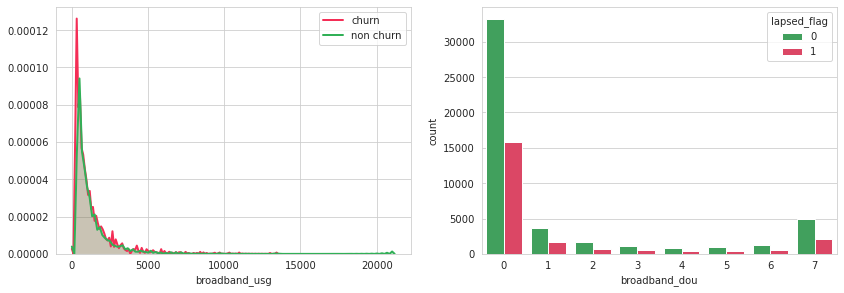

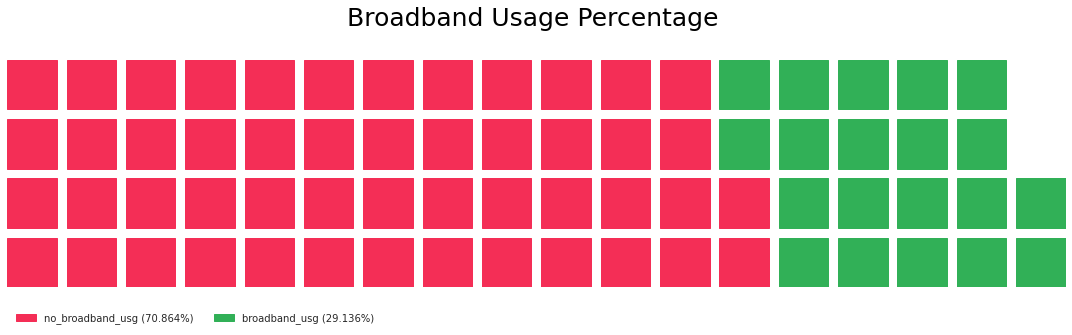

In [19]:
#palette = ['#31B057', '#F42E56']
#fig, ax = plt.subplots(1, 2, figsize = [14, 5])
fig = plt.figure(figsize = [14, 10])
ax1 = fig.add_subplot(2, 2, 1)
sns.distplot(train[train['lapsed_flag'] == 1]['broadband_usg'],
            hist = False,
            kde = True,
            kde_kws = {'shade' : True,
                       'linewidth' : 2},
            label = 'churn',
            color = '#F42E56')
sns.distplot(train[train['lapsed_flag'] == 0]['broadband_usg'],
             hist = False,
             kde = True,
             kde_kws = {'shade' : True,
                   'linewidth' : 2},
             label = 'non churn',
             color = '#31B057')
ax2 = fig.add_subplot(2, 2, 2)
sns.countplot(data = train[['broadband_dou', 'lapsed_flag']],
              hue = 'lapsed_flag',
              x = 'broadband_dou',
              palette = ['#31B057', '#F42E56'],
              hue_order = [0, 1])

#ax3 = fig.add_subplot(2, 2, (3,4))
data = {'no_broadband_usg': train[train['broadband_usg'] == 0]['broadband_usg'].shape[0],
        'broadband_usg' : train[train['broadband_usg'] != 0]['broadband_usg'].shape[0]}
fig = plt.figure(
    figsize = [15, 5],
    FigureClass=Waffle, 
    rows=4, 
    values=np.array(sorted(list(data.values()),reverse = True))/1000,
    labels=["{0} ({1}%)".format(k, '%.3f'%(v*100/train.shape[0])) for k, v in data.items()],
    colors = ('#F42E56', '#31B057'),
    #labels=["{0} ({1}%)".format(k, '%.2f'%(v*100/sum(dict(train[revenue_features].sum()).values()))) for k, v in data.items()],
    title={'label': 'Broadband Usage Percentage \n', 'loc': 'center', 'size' : 25, 'color' : 'black'},
    #labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 
            'bbox_to_anchor': (0, -0.2), 
            'ncol': len(data), 
            'framealpha': 0}
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('white')
plt.show()

Interpretation 
- broadband_rev has too many zero observations. This feature is considered not to be used in the modeling phase
- for broadband_usg it also has similar distribution between churn and non churn customers
- unlike the previous dou features, broadband_dou has different distribution. The longer the usage of internet service does not guarantee that the customers will not churn
- The majority of customers (70.86%) are not internet users

Digital features

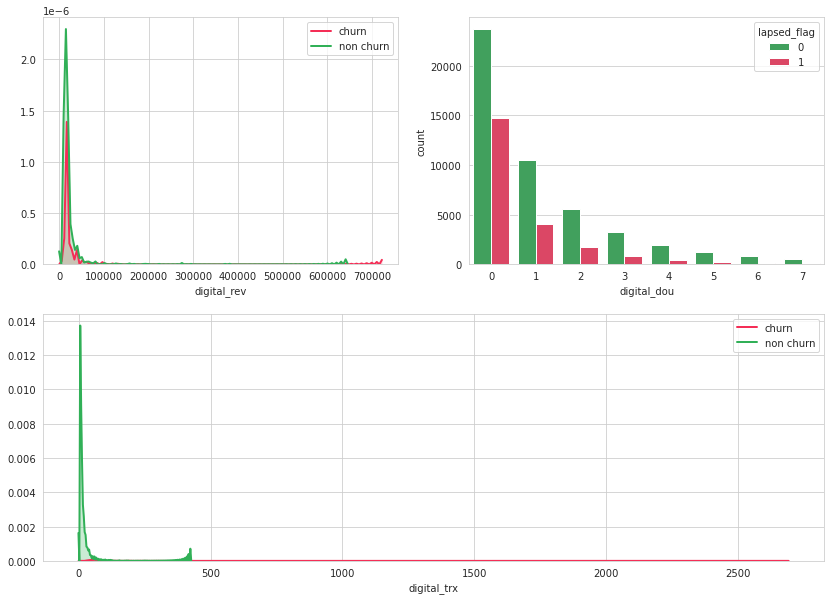

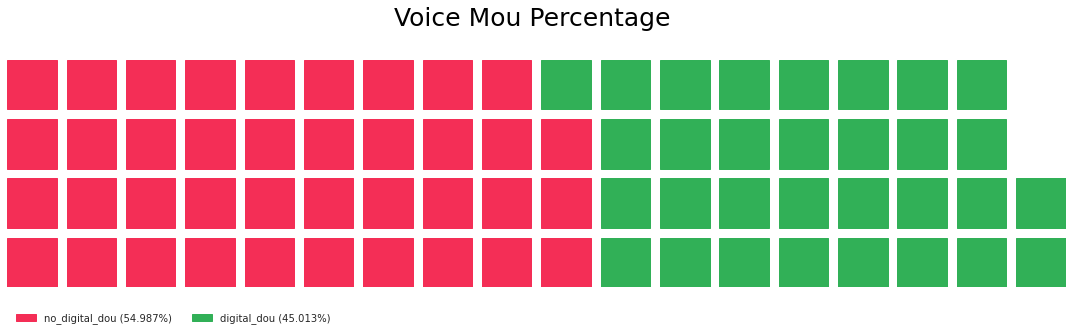

In [20]:
#'digital_rev','digital_trx', 'digital_dou'
    
#palette = ['#31B057', '#F42E56']
fig = plt.figure(figsize = [14, 10])
#plt.title('Voice Package Features')
sub1 = fig.add_subplot(2, 2, 1)
sns.distplot(train[train['lapsed_flag'] == 1]['digital_rev'],
            hist = False,
            kde = True,
            kde_kws = {'shade' : True,
                       'linewidth' : 2},
            label = 'churn',
            color = '#F42E56')
sns.distplot(train[train['lapsed_flag'] == 0]['digital_rev'],
             hist = False,
             kde = True,
             kde_kws = {'shade' : True,
                   'linewidth' : 2},
             label = 'non churn',
             color = '#31B057')

sub2 = fig.add_subplot(2, 2, 2)
sns.countplot(data = train[['digital_dou', 'lapsed_flag']],
              hue = 'lapsed_flag',
              x = 'digital_dou',
              palette = ['#31B057', '#F42E56'],
              hue_order = [0, 1])


sub3 = fig.add_subplot(2, 2, (3,4))
sns.distplot(train[train['lapsed_flag'] == 1]['digital_trx'],
            hist = False,
            kde = True,
            kde_kws = {'shade' : True,
                       'linewidth' : 2},
            label = 'churn',
            color = '#F42E56')
sns.distplot(train[train['lapsed_flag'] == 0]['digital_trx'],
             hist = False,
             kde = True,
             kde_kws = {'shade' : True,
                   'linewidth' : 2},
             label = 'non churn',
             color = '#31B057')
sub3.legend(loc = 1)

data = {'no_digital_dou': train[train['digital_dou'] == 0]['digital_dou'].shape[0],
        'digital_dou' : train[train['digital_dou'] != 0]['digital_dou'].shape[0]}
fig = plt.figure(
    figsize = [15, 5],
    FigureClass=Waffle, 
    rows=4, 
    values=np.array(sorted(list(data.values()), reverse = True))/1000,
    labels=["{0} ({1}%)".format(k, '%.3f'%(v*100/train.shape[0])) for k, v in data.items()],
    colors = ('#F42E56', '#31B057'),
    #labels=["{0} ({1}%)".format(k, '%.2f'%(v*100/sum(dict(train[revenue_features].sum()).values()))) for k, v in data.items()],
    title={'label': 'Voice Mou Percentage \n', 'loc': 'center', 'size' : 25, 'color' : 'black'},
    #labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 
            'bbox_to_anchor': (0, -0.2), 
            'ncol': len(data), 
            'framealpha': 0}
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('white')
plt.show()

Interpretation 
- digital_rev has too a lot of zero observations
- for the digital_dou feature, customers are less likely to churn the longer they use the digital service
- Quite balanced proportion between no digital service usage vs digital service usage (54.987% vs 45.013%)

Voice Package features

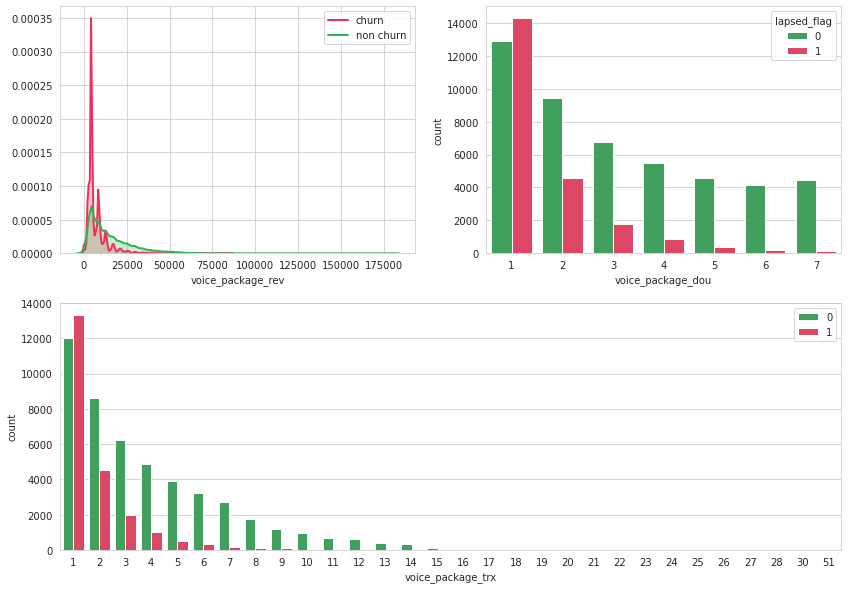

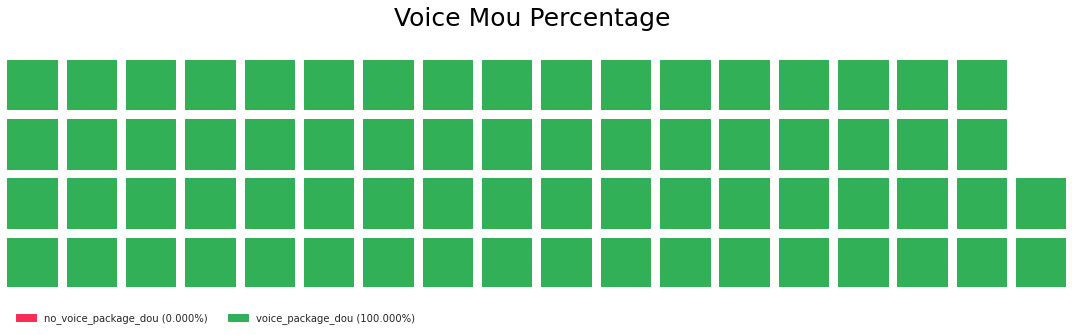

In [21]:
#palette = ['#31B057', '#F42E56']
fig = plt.figure(figsize = [14, 10])
#plt.title('Voice Package Features')
sub1 = fig.add_subplot(2, 2, 1)
sns.distplot(train[train['lapsed_flag'] == 1]['voice_package_rev'],
            hist = False,
            kde = True,
            kde_kws = {'shade' : True,
                       'linewidth' : 2},
            label = 'churn',
            color = '#F42E56')
sns.distplot(train[train['lapsed_flag'] == 0]['voice_package_rev'],
             hist = False,
             kde = True,
             kde_kws = {'shade' : True,
                   'linewidth' : 2},
             label = 'non churn',
             color = '#31B057')

sub2 = fig.add_subplot(2, 2, 2)
sns.countplot(data = train[['voice_package_dou', 'lapsed_flag']],
              hue = 'lapsed_flag',
              x = 'voice_package_dou',
              palette = ['#31B057', '#F42E56'],
              hue_order = [0, 1])


sub3 = fig.add_subplot(2, 2, (3,4))
sns.countplot(data = train[['voice_package_trx', 'lapsed_flag']],
              hue = 'lapsed_flag',
              x = 'voice_package_trx',
              palette = ['#31B057', '#F42E56'],
              hue_order = [0, 1])
sub3.legend(loc = 1)

data = {'no_voice_package_dou': train[train['voice_package_dou'] == 0]['voice_package_dou'].shape[0],
        'voice_package_dou' : train[train['voice_package_dou'] != 0]['voice_package_dou'].shape[0]}
fig = plt.figure(
    figsize = [15, 5],
    FigureClass=Waffle, 
    rows=4, 
    values=np.array(sorted(list(data.values())))/1000,
    labels=["{0} ({1}%)".format(k, '%.3f'%(v*100/train.shape[0])) for k, v in data.items()],
    colors = ('#F42E56', '#31B057'),
    #labels=["{0} ({1}%)".format(k, '%.2f'%(v*100/sum(dict(train[revenue_features].sum()).values()))) for k, v in data.items()],
    title={'label': 'Voice Mou Percentage \n', 'loc': 'center', 'size' : 25, 'color' : 'black'},
    #labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 
            'bbox_to_anchor': (0, -0.2), 
            'ncol': len(data), 
            'framealpha': 0}
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('white')
plt.show()

Interpretation 
- zero observations among churn customers of voice_package_rev are a lot more than non churn customers
- just like most of the previous features, the longer customers are using voice_package service the less likely that they will churn
- churn customers have less voice_package_trx than non churn customers
- all customers are using voice_package service at least once for the last month

Revenue features

In [22]:
revenue_features = ['rchg_rev', 
                    'voice_rev', 
                    'sms_rev', 
                    'broadband_rev', 
                    'digital_rev', 
                    'voice_package_rev']
train['total_rev'] = train[revenue_features[0]] + train[revenue_features[1]] + train[revenue_features[2]] + train[revenue_features[3]] + train[revenue_features[4]] + train[revenue_features[5]]
test['total_rev'] = test[revenue_features[0]] + test[revenue_features[1]] + test[revenue_features[2]] + test[revenue_features[3]] + test[revenue_features[4]] + test[revenue_features[5]]

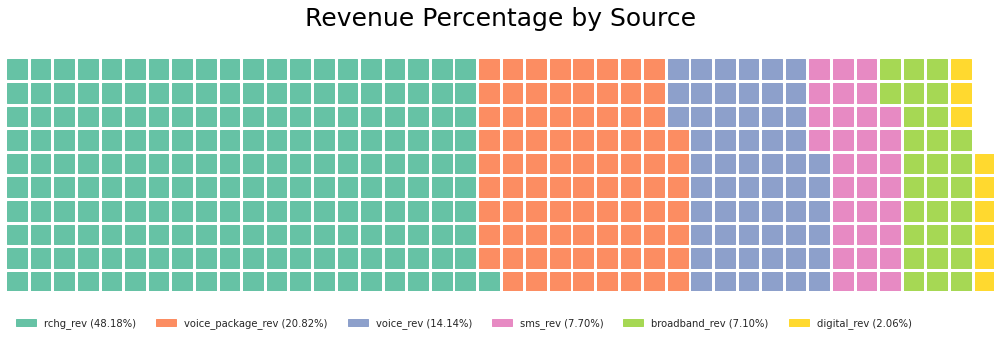

In [23]:
data = data = {'rchg_rev': sum(train['rchg_rev']),
        'voice_package_rev': sum(train['voice_package_rev']),
        'voice_rev': sum(train['voice_rev']),
        'sms_rev': sum(train['sms_rev']),
        'broadband_rev': sum(train['broadband_rev']),
        'digital_rev': sum(train['digital_rev'])}
fig = plt.figure(
    figsize = [15, 15],
    FigureClass=Waffle, 
    rows=10, 
    values=np.array(sorted(list(data.values()),reverse = True))/10000000,
    labels=["{0} ({1}%)".format(k, '%.2f'%(v*100/sum(dict(train[revenue_features].sum()).values()))) for k, v in data.items()],
    title={'label': 'Revenue Percentage by Source\n', 'loc': 'center', 'size' : 25, 'color' : 'black'},
    #labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 
            'bbox_to_anchor': (0, -0.2), 
            'ncol': len(data), 
            'framealpha': 0}
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('white')
plt.show()

About 48% of the company's revenue comes from top-up while only 2% comes from digital services. It's quite surprising because nowadays internet is getting more crucial in many societies. This may infer that the company should improve their internet service. 

Apart from small percentage of broadband_rev, it's also concluded from the previous plot that around 78% customers actually dont use the internet service. This means that the company should improve their service to attract more broadband customers.

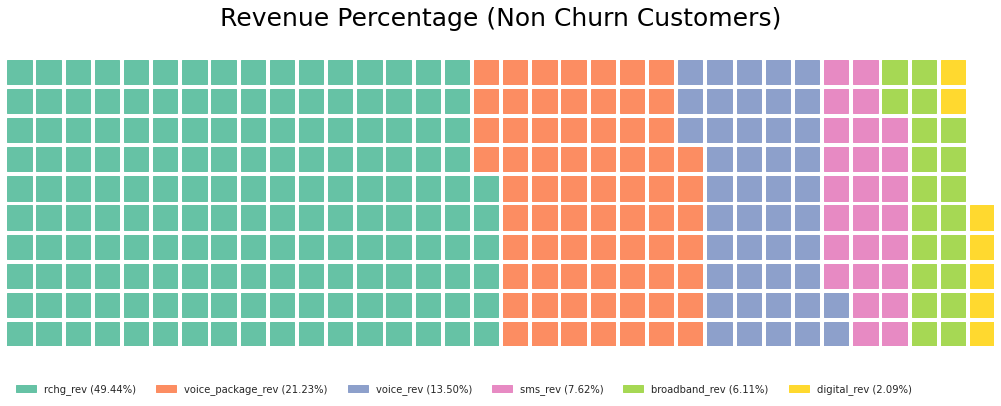

In [24]:
data = data = {'rchg_rev': sum(train[train['lapsed_flag'] == 0]['rchg_rev']),
        'voice_package_rev': sum(train[train['lapsed_flag'] == 0]['voice_package_rev']),
        'voice_rev': sum(train[train['lapsed_flag'] == 0]['voice_rev']),
        'sms_rev': sum(train[train['lapsed_flag'] == 0]['sms_rev']),
        'broadband_rev': sum(train[train['lapsed_flag'] == 0]['broadband_rev']),
        'digital_rev': sum(train[train['lapsed_flag'] == 0]['digital_rev'])}
fig = plt.figure(
    figsize = [15, 15],
    FigureClass=Waffle, 
    rows=10, 
    values=np.array(sorted(list(data.values()),reverse = True))/10000000,
    labels=["{0} ({1}%)".format(k, '%.2f'%(v*100/sum(dict(train[train['lapsed_flag'] == 0][revenue_features].sum()).values()))) for k, v in data.items()],
    title={'label': 'Revenue Percentage (Non Churn Customers)\n', 'loc': 'center', 'size' : 25, 'color' : 'black'},
    #labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 
            'bbox_to_anchor': (0, -0.2), 
            'ncol': len(data), 
            'framealpha': 0}
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('white')
plt.show()

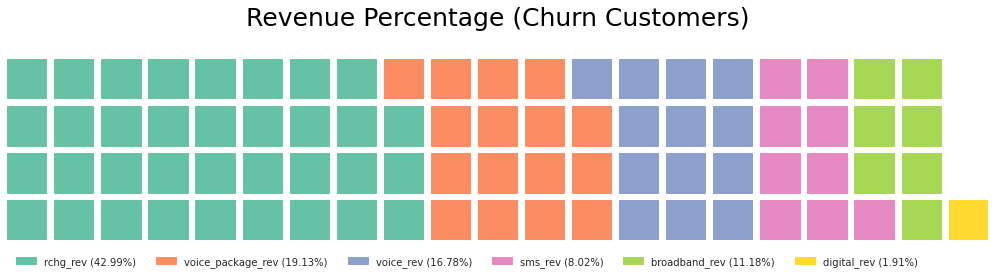

In [25]:
data = data = {'rchg_rev': sum(train[train['lapsed_flag'] == 1]['rchg_rev']),
        'voice_package_rev': sum(train[train['lapsed_flag'] == 1]['voice_package_rev']),
        'voice_rev': sum(train[train['lapsed_flag'] == 1]['voice_rev']),
        'sms_rev': sum(train[train['lapsed_flag'] == 1]['sms_rev']),
        'broadband_rev': sum(train[train['lapsed_flag'] == 1]['broadband_rev']),
        'digital_rev': sum(train[train['lapsed_flag'] == 1]['digital_rev'])}
fig = plt.figure(
    figsize = [15, 15],
    FigureClass=Waffle, 
    rows=4, 
    values=np.array(sorted(list(data.values()),reverse = True))/10000000,
    labels=["{0} ({1}%)".format(k, '%.2f'%(v*100/sum(dict(train[train['lapsed_flag'] == 1][revenue_features].sum()).values()))) for k, v in data.items()],
    title={'label': 'Revenue Percentage (Churn Customers)\n', 'loc': 'center', 'size' : 25, 'color' : 'black'},
    #labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 
            'bbox_to_anchor': (0, -0.2), 
            'ncol': len(data), 
            'framealpha': 0}
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('white')
plt.show()

The percentage of source of revenue between 2 populations (churn and non churn customers) are not very different

In [26]:
"""#fig, ax = plt.subplots(1, 4, figsize = [20, 5])
palette = ['#31B057', '#F42E56']
i = 0
values_0 = []
values_1 = []
for feature in ['voice_dou', 'sms_dou', 'broadband_dou', 'digital_dou'] :
    values_0.append(train[(train['lapsed_flag'] == 0) & (train[feature] == 0)].shape[0]/train[train['lapsed_flag'] == 0].shape[0])
    values_1.append(train[(train['lapsed_flag'] == 0) & (train[feature] != 0)].shape[0]/train[train['lapsed_flag'] == 0].shape[0])
    #sns.countplot(train[train['lapsed_flag'] == 1].sort_values(by = 'lapsed_flag', ascending = True)['lapsed_flag'], ax = ax[i], palette = palette)

vis_df = pd.DataFrame({'features' : ['voice_dou', 'sms_dou', 'broadband_dou', 'digital_dou']*2,
                       'scores' : values_0+values_1,
                       'hue' : list(np.repeat(['zero'], 4)) + list(np.repeat(['non zero'], 4))})

plt.figure(figsize = [15, 5])
sns.barplot(data = vis_df,
            y = 'scores',
            x = 'features',
            hue = 'hue',
            hue_order = ['zero', 'non zero'])
for index, value in enumerate(vis_df['scores'].iloc[:4]) :
    plt.text(index-.3, value, '%.2f'%(value*100) + '%')
    
for index, value in enumerate(vis_df['scores'].iloc[4:]) :
    plt.text(index+.1, value, '%.2f'%(value*100) + '%')
plt.title('Number-of-days features distribution of non churn customers')"""

"#fig, ax = plt.subplots(1, 4, figsize = [20, 5])\npalette = ['#31B057', '#F42E56']\ni = 0\nvalues_0 = []\nvalues_1 = []\nfor feature in ['voice_dou', 'sms_dou', 'broadband_dou', 'digital_dou'] :\n    values_0.append(train[(train['lapsed_flag'] == 0) & (train[feature] == 0)].shape[0]/train[train['lapsed_flag'] == 0].shape[0])\n    values_1.append(train[(train['lapsed_flag'] == 0) & (train[feature] != 0)].shape[0]/train[train['lapsed_flag'] == 0].shape[0])\n    #sns.countplot(train[train['lapsed_flag'] == 1].sort_values(by = 'lapsed_flag', ascending = True)['lapsed_flag'], ax = ax[i], palette = palette)\n\nvis_df = pd.DataFrame({'features' : ['voice_dou', 'sms_dou', 'broadband_dou', 'digital_dou']*2,\n                       'scores' : values_0+values_1,\n                       'hue' : list(np.repeat(['zero'], 4)) + list(np.repeat(['non zero'], 4))})\n\nplt.figure(figsize = [15, 5])\nsns.barplot(data = vis_df,\n            y = 'scores',\n            x = 'features',\n            hue = 'hu

Dou (Day) features

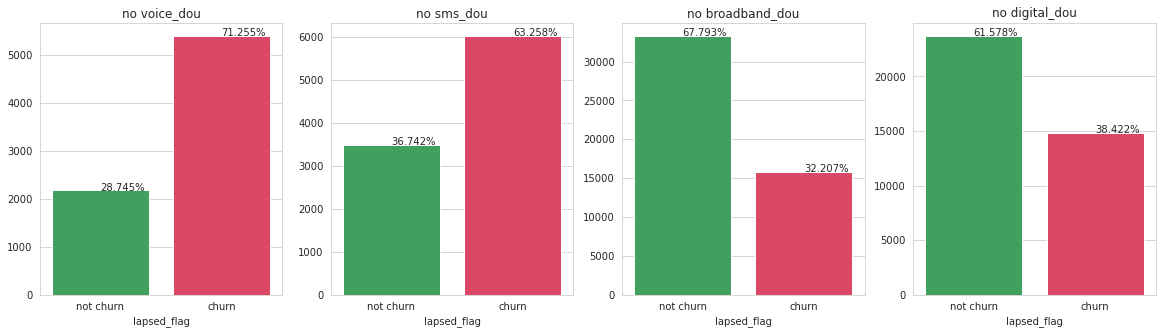

In [27]:
fig, ax = plt.subplots(1, 4, figsize = [20, 5])
palette = ['#31B057', '#F42E56']
i = 0
values_0 = []
values_1 = []
for index, feature in enumerate(['voice_dou', 'sms_dou', 'broadband_dou', 'digital_dou']) :
    values_0.append(train[(train[feature] == 0) & (train['lapsed_flag'] == 0)].shape[0]/train[train[feature] == 0].shape[0])
    values_1.append(train[(train[feature] == 0) & (train['lapsed_flag'] == 1)].shape[0]/train[train[feature] == 0].shape[0])
    sns.countplot(train[train[feature] == 0].sort_values(by = 'lapsed_flag', ascending = True)['lapsed_flag'], ax = ax[i], palette = palette)
    ax[i].set_title('no ' + feature)
    ax[i].set_ylabel('')
    ax[i].set_xticks([0,1])
    ax[i].set_xticklabels(['not churn', 'churn'])
    ax[i].text(0, values_0[index]*train[train[feature] == 0].shape[0], '%.3f'%(values_0[index]*100) + '%')
    ax[i].text(1, values_1[index]*train[train[feature] == 0].shape[0], '%.3f'%(values_1[index]*100) + '%')
    i += 1

From the countplots obtained above it can be concluded that customers without voice or sms service usage are more likely to churn.

Package last purchase feature

([<matplotlib.axis.XTick at 0x7f0b94d00250>,
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6')])

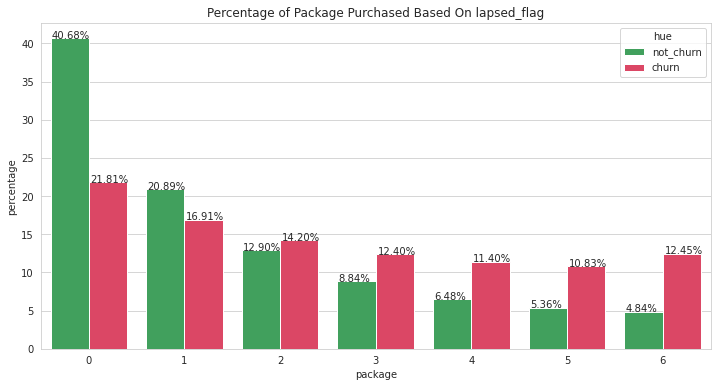

In [28]:
#sns.countplot(train['package_last_purchase'], hue = train['lapsed_flag'])
package_dict = {0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E', 5 : 'F', 6 : 'G'}
package = []
values_0 = []
values_1 = []
for i in list(range(7)) :
    package.append(package_dict[i])
    values_0.append(100*train[(train['lapsed_flag'] == 0) & (train['package_last_purchase'] == i)].shape[0]/train[train['lapsed_flag'] == 0].shape[0])
    values_1.append(100*train[(train['lapsed_flag'] == 1) & (train['package_last_purchase'] == i)].shape[0]/train[train['lapsed_flag'] == 1].shape[0])

vis_df0 = pd.DataFrame({'package' : package + package,
                       'percentage' : values_0 + values_1,
                       'hue' : list(np.repeat(['not_churn'], 7)) + list(np.repeat(['churn'], 7))})

plt.figure(figsize = [12, 6])
sns.barplot(data = vis_df0,
            y = 'percentage',
            x = 'package',
            hue = 'hue',
            palette = palette)
for index, value in enumerate(vis_df0['percentage'].iloc[:7]) :
    plt.text(index-.39, value, '%.2f'%value + '%')
    
for index, value in enumerate(vis_df0['percentage'].iloc[7:]) :
    plt.text(index+.02, value, '%.2f'%value + '%')
plt.title('Percentage of Package Purchased Based On lapsed_flag')
plt.xticks([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])

Around 60% of non churn customers purchasing package 0 or 1 while only less than 40% churn customers purchasing package 0 or 1. It looks like packages 2 to 6 are more attractive to churn customers.

In [29]:
#train['total_revenue'] = train['rchg_rev'] + train['voice_rev'] + train['sms_rev'] + train['broadband_rev'] + train['digital_rev'] + train['voice_package_rev']
#test['total_revenue'] = test['rchg_rev'] + test['voice_rev'] + test['sms_rev'] + test['broadband_rev'] + test['digital_rev'] + test['voice_package_rev']

In [30]:
#revenue_features = ['rchg_rev'] + ['voice_rev'] + ['sms_rev'] + ['broadband_rev'] + ['digital_rev'] + ['voice_package_rev']
#for feature in revenue_features :
#    train[feature+'_percentage'] = train[feature]/train['total_revenue']
#    test[feature+'_percentage'] = test[feature]/train['total_revenue']

# Feature Selection

- MSISDN will not be used for modeling
- los (length of stay) is not used for modeling because its values are not making sense. For example, there's a customer that has been a customer for 50 years

# MODELING

In [33]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [34]:
algorithms = [AdaBoostClassifier(random_state = 2),
              BaggingClassifier(random_state = 2),
              ExtraTreesClassifier(random_state = 2),
              GradientBoostingClassifier(random_state = 2),
              RandomForestClassifier(random_state = 2),
              #SVC(),
              #LogisticRegression(),
              #GaussianNB(),
              XGBClassifier(random_state = 2),
              LGBMClassifier(random_state = 2),
              CatBoostClassifier(random_state = 2, verbose = False),
              CatBoostClassifier(random_state = 2, verbose = False,
                                 loss_function='Tweedie')]

algo = []
cv_baseline_accuracy_1 = []
cv_baseline_f1_1 = []
for algorithm in tqdm(algorithms) :
    algo.append(type(algorithm).__name__)
    cv_baseline_accuracy_1.append(cross_val_score(algorithm,
                                                  train[list(train_original.drop(columns = ['MSISDN', 
                                                                                            'los',
                                                                                            'lapsed_flag']).columns)],
                                                  train['lapsed_flag'],
                                                  cv = StratifiedKFold(5),
                                                  scoring = 'accuracy').mean())
    
    cv_baseline_f1_1.append(cross_val_score(algorithm,
                                                  train[list(train_original.drop(columns = ['MSISDN', 
                                                                                            'los',
                                                                                            'lapsed_flag']).columns)],
                                                  train['lapsed_flag'],
                                                  cv = StratifiedKFold(5),
                                                  scoring = 'f1').mean())

In [36]:
algorithms = [AdaBoostClassifier(random_state = 2),
              BaggingClassifier(random_state = 2),
              ExtraTreesClassifier(random_state = 2),
              GradientBoostingClassifier(random_state = 2),
              RandomForestClassifier(random_state = 2),
              #SVC(),
              #LogisticRegression(),
              #GaussianNB(),
              XGBClassifier(random_state = 2),
              LGBMClassifier(random_state = 2),
              CatBoostClassifier(random_state = 2, verbose = False),
              CatBoostClassifier(random_state = 2, verbose = False,
                                 loss_function='Tweedie')]

algo = []
cv_baseline_accuracy_2 = []
cv_baseline_f1_2 = []
for algorithm in tqdm(algorithms) :
    algo.append(type(algorithm).__name__)
    cv_baseline_accuracy_2.append(cross_val_score(algorithm,
                                                  train.drop(columns = ['lapsed_flag', 
                                                                        'broadband_rev', 
                                                                        'broadband_usg', 
                                                                        'MSISDN']),
                                                  train['lapsed_flag'],
                                                  cv = StratifiedKFold(5),
                                                  scoring = 'accuracy').mean())
    
    cv_baseline_f1_2.append(cross_val_score(algorithm,
                                                  train.drop(columns = ['lapsed_flag', 
                                                                        'broadband_rev', 
                                                                        'broadband_usg', 
                                                                        'MSISDN']),
                                                  train['lapsed_flag'],
                                                  cv = StratifiedKFold(5),
                                                  scoring = 'f1').mean())

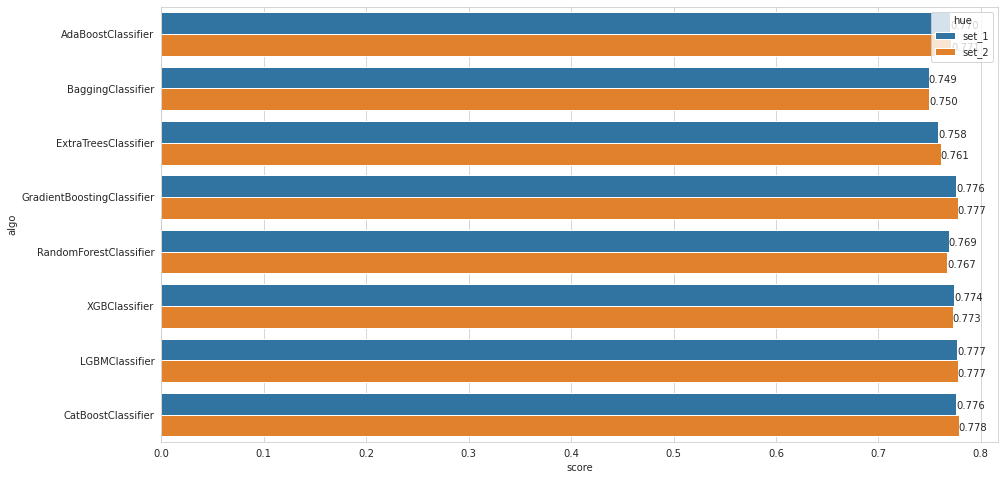

In [38]:
vis_df = pd.DataFrame({'algo' : algo+algo,
                       'score' : cv_baseline_accuracy_1 + cv_baseline_accuracy_2,
                       'hue' : list(np.repeat(['set_1'], 9)) + list(np.repeat(['set_2'], 9))}
                     )
plt.figure(figsize = [15, 8])
sns.barplot(data = vis_df,
            x = 'score',
            y = 'algo',
            hue = 'hue')
for index, value in enumerate(vis_df['score'].iloc[:9]) :
    plt.text(value, index-.1, '%.3f'%value)
    
for index, value in enumerate(vis_df['score'].iloc[9:]) :
    plt.text(value, index+.3, '%.3f'%value)

LGBMClassifier is chosen for modeling phase

Text(0.5, 1.0, 'Feature Importance Plot Using LightGBM Classifier')

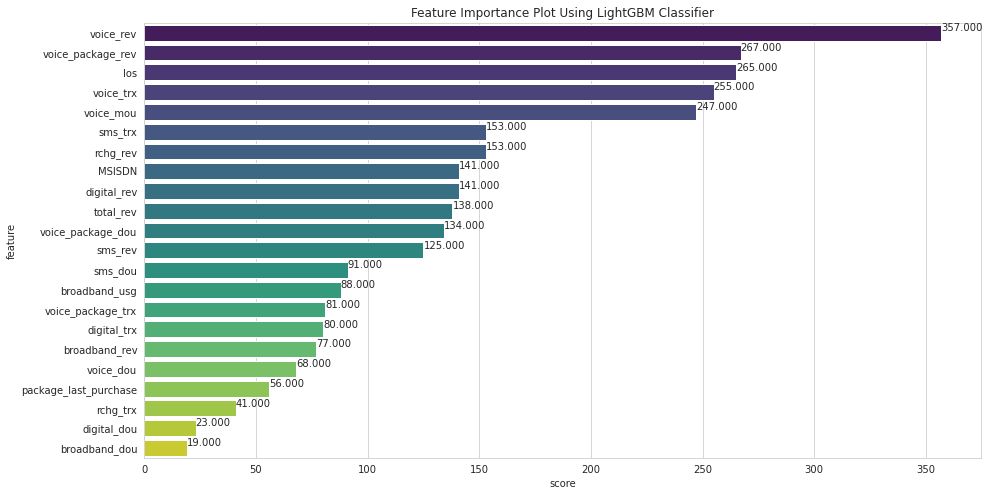

In [46]:
model = LGBMClassifier(random_state = 2)
model.fit(train.drop(columns = ['lapsed_flag']),
          train['lapsed_flag'])
plt.figure(figsize = [15, 8])
sns.barplot(data = pd.DataFrame({'feature' : list(train.drop(columns = ['lapsed_flag']).columns),
                                 'score' : model.feature_importances_}).sort_values(by = 'score',
                                                                                    ascending = False),
            x = 'score',
            y = 'feature',
            palette = 'viridis')
for index, value in enumerate(sorted(model.feature_importances_, reverse = True)) :
    plt.text(value, index+.1, '%.3f'%value)
plt.title('Feature Importance Plot Using LightGBM Classifier')